# Multispecies occupancy models in `unmarked`

### Ken Kellner

# Outline

1. Introduction
2. Model description
3. Fit model with `unmarked`
4. Marginal and conditional occupancy
5. Model fitting challenges

# Introduction

* Species interactions can drive species distributions
* Examples: 
    - competition
    - predator-prey
    - parasite-host

![](Fox_eating_mole.jpg)

### How can we model interactions?

* Direct observations of interactions (e.g. predation events)
* Indirect:
    - Over time
    - Over space

Facilited by proliferation of passive detector data (e.g. cameras)

### Interactions over time

Activity pattern analysis (e.g. Ridout and Linkie 2009, `overlap` R package)

![](activity.png)

Doesn't necessarily test if species are typically found in the same *locations*

### Interactions in space

Multispecies occupancy models

Don't necessary test if species are active at *the same time*

### Types of multispecies occupancy models

* 2+ species, no interactions explicitly modeled (e.g. community occupancy models; AHM1 Chap 11)
* Two species, species interaction factor, sometimes has numerical issues (MacKenzie et al. 2004)
* Two species, asymmetric interactions (Waddle et al. 2010, Richmond et al. 2010)
* Models above available in PRESENCE, MARK software

* 2+ species, symmetric interactions (Rota et al. 2016, AHM2 Chap 8) **<- focus of this session**

# Model description

* Suppose you sample for $S = 2$ species at N sites, $i=1...N$
* Then the latent state $\textbf{Z}_i$ at site $i$ is a vector of length 2, and there are four possible states:

$$ \textbf{Z}_i = \{11\}, \{10\},\{01\}, or \{00\} $$

$$ \textbf{Z}_i \sim \mathrm{MultivariateBernoulli}(\boldsymbol\psi) $$

$$ pr(Z_i) = \{11\} \Longrightarrow \psi_{11} $$
$$ pr(Z_i) = \{10\} \Longrightarrow \psi_{10} $$
$$ pr(Z_i) = \{01\} \Longrightarrow \psi_{01} $$
$$ pr(Z_i) = \{00\} \Longrightarrow \psi_{00} $$

$$ \sum{\boldsymbol\psi} = 1$$

### How do we get the values of $\psi$?

### Start with the "natural parameters", $f$

$f_1$: Term associated with occupancy of species 1 by itself

$f_2$: Term associated with occupancy of species 2 by itself

$f_{12}$: Interaction term between the two species

If $f_{12}$ is positive, presence of one species increases occupancy probability of the other

If $f_{12}$ is negative, presence of one species decreases occupancy probability of the other

### Calculating $\psi$: the multinomial logit link

Each element of $\mathbf{\psi}$ is a function of the natural parameters $f$.

$$ 
\begin{align}
\psi_{11} & \propto exp(f_{1} + f_{2} + f_{12}) \\
\psi_{10} & \propto exp(f_{1}) \\
\psi_{01} & \propto exp(f_{2}) \\
\psi_{00} & \propto exp(0) = 1
\end{align}
$$

Making sure $\mathbf{\psi}$ sums to 1:

$$ \psi_{11} = \frac{exp(f_{1} + f_{2} + f_{12})}{1 + exp(f_{1}) + exp(f_{2}) + exp(f_{1} + f_{2} + f_{12})} $$

$$ \psi_{10} = \frac{exp(f_{1})}{1 + exp(f_{1}) + exp(f_{2}) + exp(f_{1} + f_{2} + f_{12})} $$

$$ \psi_{01} = \frac{exp(f_{2})}{1 + exp(f_{1}) + exp(f_{2}) + exp(f_{1} + f_{2} + f_{12})} $$

$$ \psi_{00} = \frac{1}{1 + exp(f_{1}) + exp(f_{2}) + exp(f_{1} + f_{2} + f_{12})} $$

### A note on removing interaction terms

Original math:

$$ 
\begin{align}
\psi_{11} & \propto exp(f_{1} + f_{2} + f_{12}) \\
\psi_{10} & \propto exp(f_{1}) \\
\psi_{01} & \propto exp(f_{2}) \\
\psi_{00} & \propto 1
\end{align}
$$


What if we force $f_{12} = 0$?

$$ 
\begin{align}
\psi_{11} & \propto exp(f_{1} + f_{2}) \\
\psi_{10} & \propto exp(f_{1}) \\
\psi_{01} & \propto exp(f_{2}) \\
\psi_{00} & \propto 1
\end{align}
$$

This is equivalent to fitting two separate occupancy models. I'll show this later.

### Modeling detection

* It's the same as single-species occupancy
* Each species gets its own separate detection model

For example, detection/nondetection of species 1 at site $i$ and occasion $j$ can be modeled as

$$ y_{1,ij} \sim \mathrm{Bernoulli}(p_{1} \cdot z_{1,i}) $$

where $z_{1,i}$ is the element 1 of $Z_i$ (i.e., latent presence/absence of species 1 at site $i$) and $p_{1}$ is the species 1 detection probability

# Multispecies occupancy model in `unmarked`

In [1]:
library(unmarked)

We will use the function `occuMulti`

![](occuMulti_setup.png)

## Set up the input data

### Example data

![](coyote1.jpg) ![](redfox1.jpg)

In [2]:
data(MesoCarnivores)
lapply(MesoCarnivores, head) # look at raw data

X1,X2,X3
0,0,0
0,0,0
0,0,0
0,0,0
0,0,0
0,0,0
X1,X2,X3
0,0,0
0,0,0
0,0,0


### Formatting the data

We will create an `unmarkedFrameOccuMulti`. 

The main difference from `unmarkedFrameOccu` is that you have >1 matrix of observations: we now have one `y` per species.


![](umf_om_construction.png)

Get some more detail by looking at the help file for `unmarkedFrameOccuMulti`:

In [ ]:
?unmarkedFrameOccuMulti

### y list

The first three elements of `MesoCarnivores` are the y-matrices. To keep things simple, we'll just use coyote and red fox.

Notice that the resulting list is **named**: this is important!

In [3]:
ylist <- MesoCarnivores[c(2:3)]
lapply(ylist, head) # look at first few rows

X1,X2,X3
0,0,0
0,0,0
0,0,0
0,0,0
0,0,0
0,0,0
X1,X2,X3
0,0,0
0,0,0
0,0,1


### Site covariates

The last element of the `MesoCarnivores` list is a data frame of site covariates:

In [4]:
site_covs <- MesoCarnivores$sitecovs
head(site_covs)

,Dist_5km,HDens_5km,Latitude,Longitude,People_site,Trail
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.04,9.345258,0.3899441,-0.7723958,0.857,1
2,0.03,9.499197,0.3899250,-0.7723920,0.002,0
3,0.03,9.647173,0.3899111,-0.7723954,0.387,1
4,0.03,9.598066,0.3899166,-0.7723972,0.003,0
5,0.03,9.607825,0.3899179,-0.7724004,0.000,0
6,0.03,9.748791,0.3899058,-0.7724046,0.443,1


### Construct the unmarked frame

In [60]:
umf <- unmarkedFrameOccuMulti(y=ylist, siteCovs=site_covs)
head(umf)

Data frame representation of unmarkedFrame object.
Only showing observation matrix for species 1.
   y.1 y.2 y.3 Dist_5km HDens_5km  Latitude  Longitude People_site Trail
1    0   0   0     0.04  9.345258 0.3899441 -0.7723958       0.857     1
2    0   0   0     0.03  9.499197 0.3899250 -0.7723920       0.002     0
3    0   0   0     0.03  9.647173 0.3899111 -0.7723954       0.387     1
4    0   0   0     0.03  9.598066 0.3899166 -0.7723972       0.003     0
5    0   0   0     0.03  9.607825 0.3899179 -0.7724004       0.000     0
6    0   0   0     0.03  9.748791 0.3899058 -0.7724046       0.443     1
7    0   0   0     0.03  9.715359 0.3899097 -0.7724065       0.000     0
8    0   0   0     0.03  9.685091 0.3899135 -0.7724103       0.000     0
9    0   0   0     0.04  9.051558 0.3899955 -0.7724561       0.002     0
10   0   0   0     0.04  9.031836 0.3899971 -0.7724504       0.000     0

In [6]:
summary(umf)

unmarkedFrame Object

1437 sites
2 species: coyote redfox 
Maximum number of observations per site: 3 
Mean number of observations per site:
coyote: 3  redfox: 3  
Sites with at least one detection:
coyote: 401  redfox: 161  
Tabulation of y observations:
coyote:
   0    1 
3685  626 
redfox:
   0    1 
4054  257 

Site-level covariates:
    Dist_5km         HDens_5km           Latitude        Longitude      
 Min.   :0.00000   Min.   :  0.0000   Min.   :0.3454   Min.   :-0.8539  
 1st Qu.:0.00000   1st Qu.:  0.2073   1st Qu.:0.3567   1st Qu.:-0.8009  
 Median :0.00000   Median :  0.7310   Median :0.3753   Median :-0.7940  
 Mean   :0.01419   Mean   :  8.4532   Mean   :0.3726   Mean   :-0.7969  
 3rd Qu.:0.02000   3rd Qu.:  3.0219   3rd Qu.:0.3863   3rd Qu.:-0.7801  
 Max.   :0.13000   Max.   :186.6694   Max.   :0.3967   Max.   :-0.7690  
  People_site          Trail       
 Min.   :0.00000   Min.   :0.0000  
 1st Qu.:0.00000   1st Qu.:0.0000  
 Median :0.00000   Median :0.0000  
 Mean

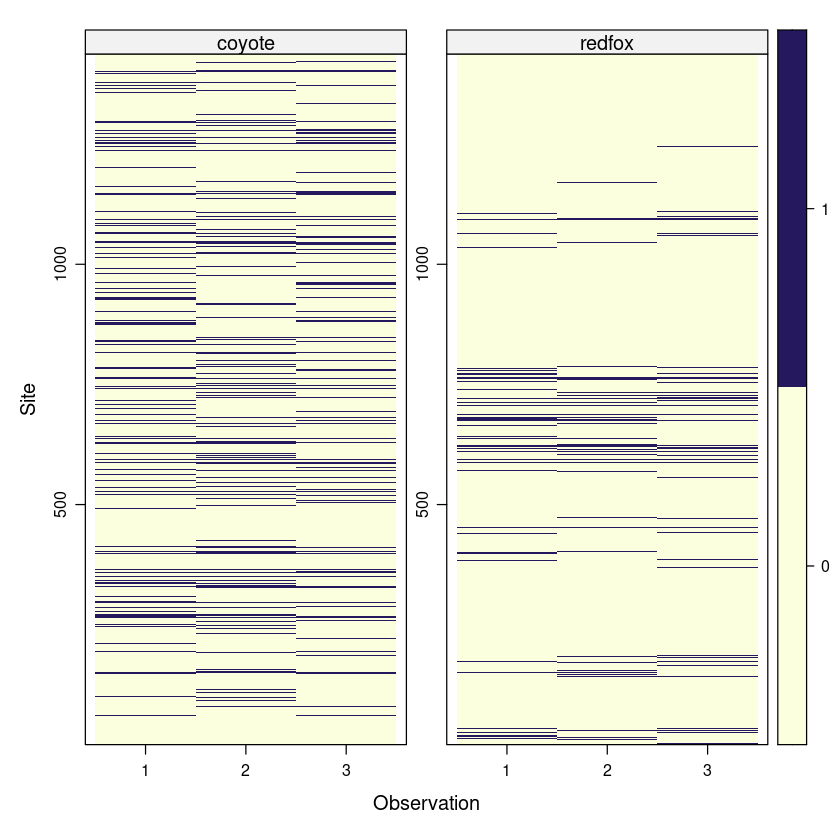

In [7]:
plot(umf)

## Set up the formulas

![](occuMulti_setup.png)

### `stateformulas`

While `occu` had a single formula for occupancy, `occuMulti` requires one formula per natural parameter $f$, organized into a `stateformulas` vector.

It can be hard to keep track of how many natural parameters there are and what each one represents.

$$ 
\begin{align}
\psi_{11} & \propto exp(f_{1} + f_{2} + f_{12}) \\
\psi_{10} & \propto exp(f_{1}) \\
\psi_{01} & \propto exp(f_{2}) \\
\psi_{00} & \propto exp(0) = 1
\end{align}
$$

It can be helpful to look at the $f$-design matrix, which is generated by `unmarkedFrameOccuMulti`.

In [8]:
umf@fDesign

,f1[coyote],f2[redfox],f3[coyote:redfox]
psi[11],1,1,1
psi[10],1,0,0
psi[01],0,1,0
psi[00],0,0,0


The number and order of the formulas in the `stateformulas` vector should match the column names of this matrix.
Therefore we'll need 3 formulas total.
For this model we'll set the 1st-order $f$ parameters to be a function of (standardized) housing density. The interaction term will be intercept-only.

Our `stateformulas` should look like this:

In [9]:
stateformulas <- c("~scale(HDens_5km)","~scale(HDens_5km)","~1")
stateformulas

[1] "~scale(HDens_5km)" "~scale(HDens_5km)" "~1"

Notice that the formulas are **strings** (each wrapped in `""`). This is required and is just working around some R limitations.

Also notice the calls to `scale()`: this will automatically scale the covariate.

### `detformulas`

This one is easier, there is just one formula per species, so there should be 2 total.

Intercept-only models for both species:

In [10]:
detformulas <- c("~1","~1")
detformulas

[1] "~1" "~1"

## Run `occuMulti`

We now have all the pieces we need (`unmarkedFrameOccuMulti`, `stateformulas`, `detformulas`) needed to run a model.

In [ ]:
?occuMulti

In [11]:
mod_hdens <- occuMulti(detformulas=detformulas, stateformulas=stateformulas, data=umf)
mod_hdens


Call:
occuMulti(detformulas = detformulas, stateformulas = stateformulas, 
    data = umf, maxOrder = 2L)

Occupancy:
                             Estimate     SE         z  P(>|z|)
[coyote] (Intercept)        -0.786370 0.0815  -9.64306 5.26e-22
[coyote] scale(HDens_5km)   -0.000668 0.0691  -0.00966 9.92e-01
[redfox] (Intercept)        -2.391812 0.1598 -14.96684 1.21e-50
[redfox] scale(HDens_5km)    0.504456 0.0813   6.20113 5.61e-10
[coyote:redfox] (Intercept)  1.062921 0.2322   4.57859 4.68e-06

Detection:
                     Estimate     SE     z  P(>|z|)
[coyote] (Intercept)   -0.333 0.0764 -4.36 1.31e-05
[redfox] (Intercept)   -0.251 0.1180 -2.13 3.34e-02

AIC: 4800.859 

## Model goodness-of-fit

Fit statistic: sum of squared Pearson residuals across all species

$$ SSE = \sum_{s=1}^S \sum_{i=1}^{M\cdot J} \frac{\left(y_{i} - \hat{y}_{i}\right)^2}{\hat{y}_i \cdot (1-\hat{y}_i)} $$

$$ \hat{y}_i = \psi_{marg_i} \cdot p_i $$

In [12]:
pearson2 <- function(fit){
  y <- fit@data@ylist
  S <- length(y)
  yhat <- fitted(fit)

  out <- lapply(1:S, function(s){
    (y[[s]] - yhat[[s]])^2 / (yhat[[s]] * (1-yhat[[s]]))
  })

  sum(unlist(out))
}

$\psi_{marg_i}$ is the marginal occupancy for the species (I'll talk about it more in a minute)

Run a parametric bootstrap (takes a while):

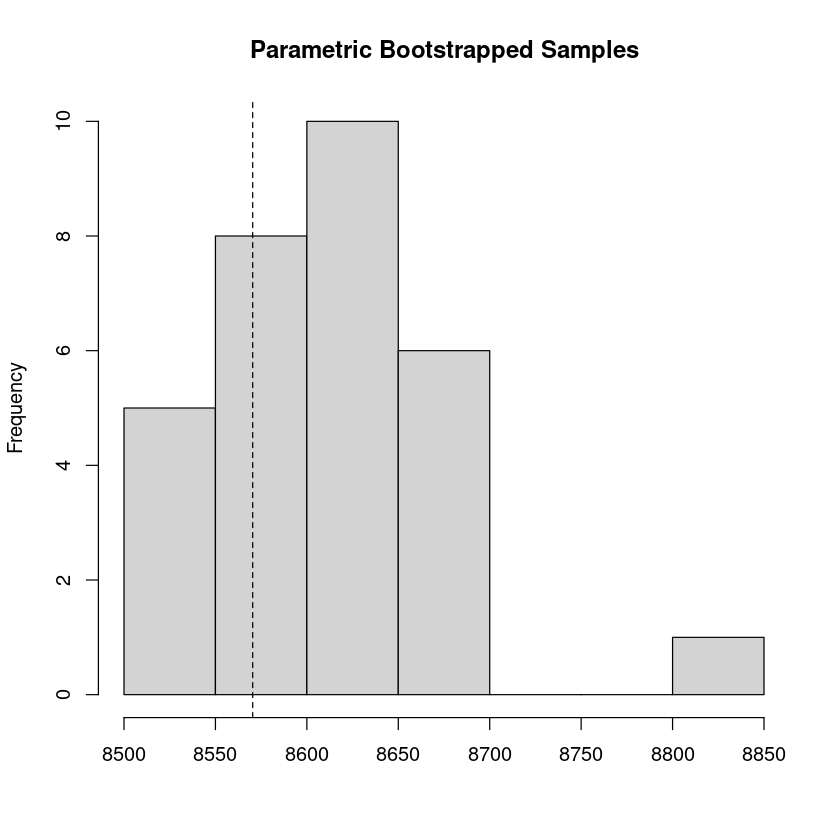

In [13]:
pb <- parboot(mod_hdens, statistic = pearson2, nsim = 30)
plot(pb)

Dotted line (real dataset) should fall within the histogram (simulated datasets).

There isn't a function available for the MB test for multispecies models (yet?)

## Inference

In [14]:
mod_hdens


Call:
occuMulti(detformulas = detformulas, stateformulas = stateformulas, 
    data = umf, maxOrder = 2L)

Occupancy:
                             Estimate     SE         z  P(>|z|)
[coyote] (Intercept)        -0.786370 0.0815  -9.64306 5.26e-22
[coyote] scale(HDens_5km)   -0.000668 0.0691  -0.00966 9.92e-01
[redfox] (Intercept)        -2.391812 0.1598 -14.96684 1.21e-50
[redfox] scale(HDens_5km)    0.504456 0.0813   6.20113 5.61e-10
[coyote:redfox] (Intercept)  1.062921 0.2322   4.57859 4.68e-06

Detection:
                     Estimate     SE     z  P(>|z|)
[coyote] (Intercept)   -0.333 0.0764 -4.36 1.31e-05
[redfox] (Intercept)   -0.251 0.1180 -2.13 3.34e-02

AIC: 4800.859 

**Inference about species "in isolation"**

Or "first order" effects

* Coyote occupancy is higher than red fox (when the other species is absent!)
* No relationship between coyote occupancy and housing density
* Positive relationship between red fox and housing density

**Inference about interaction**

"Second order" effects (because we're talking about 2-way or pairwise interaction)

* Positive interaction between coyote and fox, and 95% CI doesn't overlap 0

* At sites where coyote is present, red fox is more likely to be present (higher occupancy)
* At sites were red fox is present, coyote is more likely to be present

i.e., the interaction is **symmetric**

### Exercise

* Add `Dist_5km` (disturbance) as a site-level covariate on one or more occupancy parameters
* Add `Trail` as a covariate on detection probability for both species
* Name the model object `mod_dist`
* If you have time, check goodness-of-fit with `parboot`

In [15]:
head(umf)

Data frame representation of unmarkedFrame object.
Only showing observation matrix for species 1.
   y.1 y.2 y.3 Dist_5km HDens_5km  Latitude  Longitude People_site Trail
1    0   0   0     0.04  9.345258 0.3899441 -0.7723958       0.857     1
2    0   0   0     0.03  9.499197 0.3899250 -0.7723920       0.002     0
3    0   0   0     0.03  9.647173 0.3899111 -0.7723954       0.387     1
4    0   0   0     0.03  9.598066 0.3899166 -0.7723972       0.003     0
5    0   0   0     0.03  9.607825 0.3899179 -0.7724004       0.000     0
6    0   0   0     0.03  9.748791 0.3899058 -0.7724046       0.443     1
7    0   0   0     0.03  9.715359 0.3899097 -0.7724065       0.000     0
8    0   0   0     0.03  9.685091 0.3899135 -0.7724103       0.000     0
9    0   0   0     0.04  9.051558 0.3899955 -0.7724561       0.002     0
10   0   0   0     0.04  9.031836 0.3899971 -0.7724504       0.000     0

In [16]:
stateform2 <- c("~scale(Dist_5km)","~scale(Dist_5km)","~scale(Dist_5km)")
detform2 <- c("~Trail", "~Trail")
mod_dist <- occuMulti(detform2, stateform2, umf)
mod_dist


Call:
occuMulti(detformulas = detform2, stateformulas = stateform2, 
    data = umf, maxOrder = 2L)

Occupancy:
                                Estimate     SE      z  P(>|z|)
[coyote] (Intercept)              0.0340 0.1149  0.296 7.67e-01
[coyote] scale(Dist_5km)          0.0287 0.0925  0.310 7.56e-01
[redfox] (Intercept)             -2.0294 0.2254 -9.003 2.19e-19
[redfox] scale(Dist_5km)         -0.2673 0.2288 -1.169 2.43e-01
[coyote:redfox] (Intercept)       0.7984 0.2829  2.823 4.76e-03
[coyote:redfox] scale(Dist_5km)  -0.0351 0.2954 -0.119 9.06e-01

Detection:
                     Estimate    SE      z  P(>|z|)
[coyote] (Intercept)    -1.94 0.100 -19.38 1.20e-83
[coyote] Trail           2.15 0.123  17.48 2.20e-68
[redfox] (Intercept)    -1.38 0.184  -7.50 6.37e-14
[redfox] Trail           1.61 0.219   7.34 2.07e-13

AIC: 4555.673 

In [ ]:
pb2 <- parboot(mod_dist, statistic = pearson2, nsim=30)
plot(pb2)

### Occupancy probabilities

To get the expected probability $\boldsymbol\psi$ for each occupancy state at each site, use `predict`.
This gives you the probabilities along with standard errors and a 95% CI.

In [17]:
occ_prob <- predict(mod_hdens, type="state")
lapply(occ_prob, head)

Bootstrapping confidence intervals with 100 samples



psi[11],psi[10],psi[01],psi[00]
0.07332333,0.2725955,0.05560920,0.5984720
0.07349727,0.2724991,0.05574131,0.5982624
0.07366480,0.2724062,0.05586856,0.5980605
0.07360916,0.2724370,0.05582630,0.5981275
0.07362022,0.2724309,0.05583470,0.5981142
0.07378003,0.2723423,0.05595609,0.5979216
psi[11],psi[10],psi[01],psi[00]
0.008389343,0.01601586,0.008638850,0.01788425
0.008404061,0.01602268,0.008656270,0.01789938
0.008418310,0.01602954,0.008673113,0.01791421


Rows should sum to 1:

In [18]:
head(apply(occ_prob$Predicted, 1, sum))

[1] 1 1 1 1 1 1

### Marginal occupancy

You might want to know the *marginal* occupancy of species 2 (red fox) at a site, which is the probability of red fox occupancy regardless of the occupancy states of other species.

This is calculated by summing $\psi$ for all states in which red fox is present:

$$ \psi_{marg,fox} = \psi_{11}+\psi_{01} $$

Calculate manually:

In [19]:
head(occ_prob$Predicted)

psi[11],psi[10],psi[01],psi[00]
0.07332333,0.2725955,0.05560920,0.5984720
0.07349727,0.2724991,0.05574131,0.5982624
0.07366480,0.2724062,0.05586856,0.5980605
0.07360916,0.2724370,0.05582630,0.5981275
0.07362022,0.2724309,0.05583470,0.5981142
0.07378003,0.2723423,0.05595609,0.5979216


In [20]:
marg_manual <- occ_prob$Predicted[,1] + occ_prob$Predicted[,3]
head(marg_manual)

[1] 0.1289325 0.1292386 0.1295334 0.1294355 0.1294549 0.1297361

You can also do this by specifying the `species` argument in `predict`.

In [21]:
redfox_marginal <- predict(mod_hdens, type="state", species="redfox")
head(redfox_marginal)

Bootstrapping confidence intervals with 100 samples



,Predicted,SE,lower,upper
,<dbl>,<dbl>,<dbl>,<dbl>
1,0.1289325,0.01057213,0.1115670,0.1523760
2,0.1292386,0.01059454,0.1118108,0.1527684
3,0.1295334,0.01061628,0.1120457,0.1531465
4,0.1294355,0.01060904,0.1119677,0.1530209
5,0.1294549,0.01061048,0.1119832,0.1530459
6,0.1297361,0.01063133,0.1122072,0.1534065


#### Plotting marginal occupancy

Compare across species (at site 1 only) with a plot:

In [22]:
coy_marginal <- predict(mod_hdens, type='state', species="coyote") # get coyote

marg_plot_dat <- rbind(redfox_marginal[1,], coy_marginal[1,])
marg_plot_dat$Species <- c("Red fox", "Coyote")
marg_plot_dat

Bootstrapping confidence intervals with 100 samples



Predicted,SE,lower,upper,Species
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.1289325,0.01057213,0.1115670,0.1523760,Red fox
0.3459189,0.01555310,0.3184539,0.3816518,Coyote


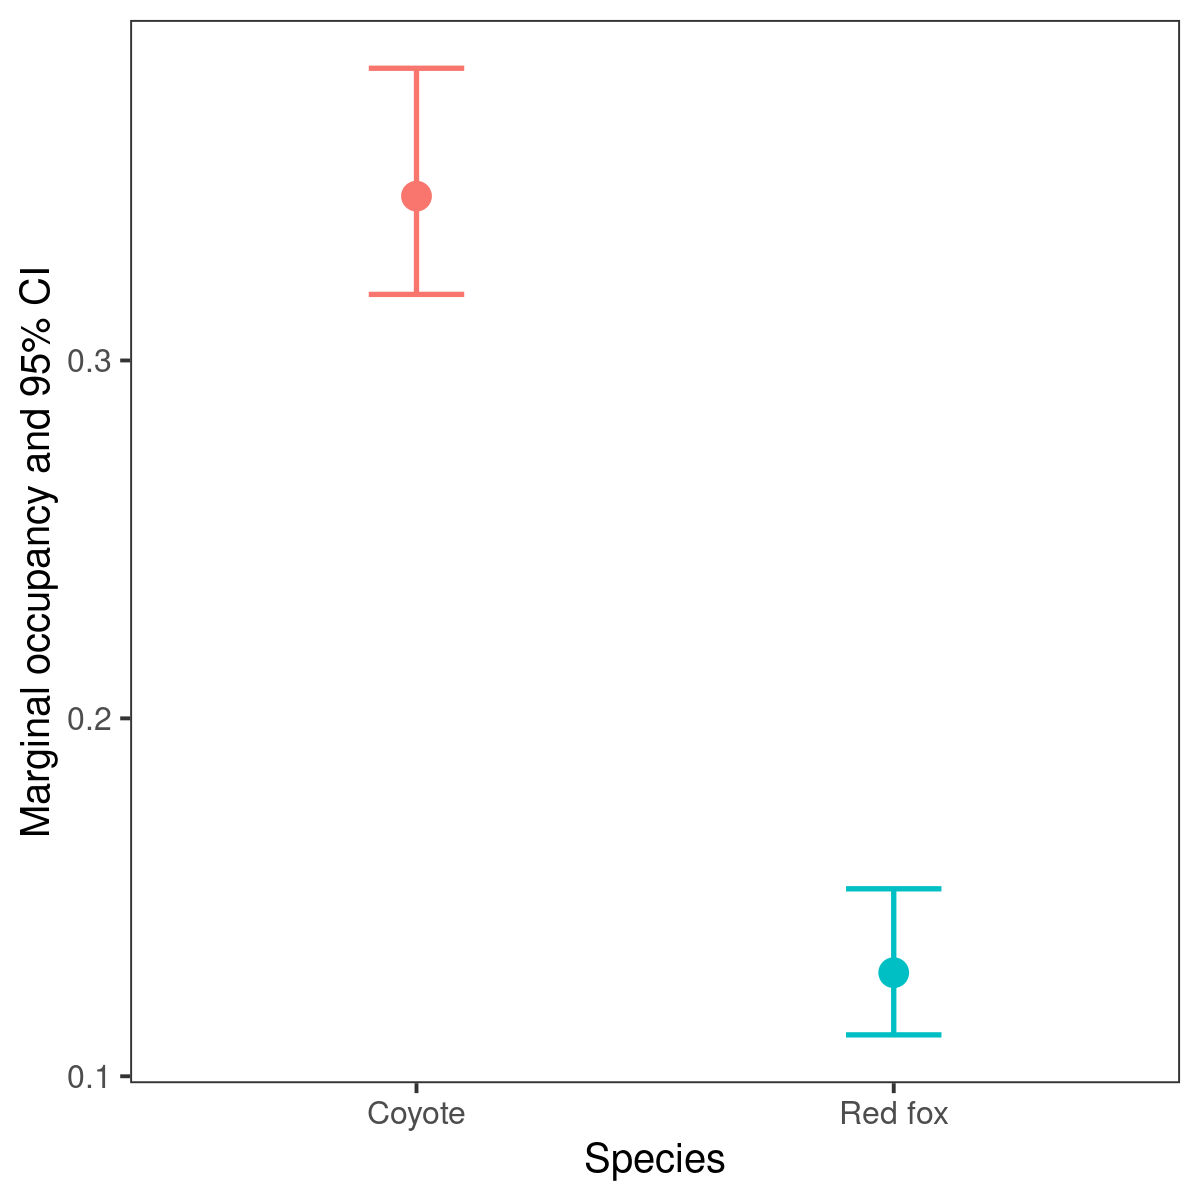

In [23]:
library(ggplot2)
options(repr.plot.width=10, repr.plot.height=10)

ggplot(data = marg_plot_dat, aes(x=Species, col=Species)) +
  geom_errorbar(aes(ymin=lower, ymax=upper), width = 0.2, linewidth=1.5) +
  geom_point(aes(y=Predicted), size=8) +
  theme_bw(base_size=24) +
  theme(panel.grid = element_blank(), legend.position='none') +
  labs(y = "Marginal occupancy and 95% CI", x = "Species")

### Conditional occupancy

Alternatively, you might want to know the probability of occupancy of one species, conditional on the presence of another.

For example, the probability of red fox occupancy, conditional on coyote presence:

$$ \psi_{fox, coy} = \frac{\psi_{{11}}}{\psi_{{10}} + \psi_{{11}}}$$

In [24]:
lapply(occ_prob, head)

psi[11],psi[10],psi[01],psi[00]
0.07332333,0.2725955,0.05560920,0.5984720
0.07349727,0.2724991,0.05574131,0.5982624
0.07366480,0.2724062,0.05586856,0.5980605
0.07360916,0.2724370,0.05582630,0.5981275
0.07362022,0.2724309,0.05583470,0.5981142
0.07378003,0.2723423,0.05595609,0.5979216
psi[11],psi[10],psi[01],psi[00]
0.008389343,0.01601586,0.008638850,0.01788425
0.008404061,0.01602268,0.008656270,0.01789938
0.008418310,0.01602954,0.008673113,0.01791421


In [25]:
cond_manual <- occ_prob$Predicted[,1] / (occ_prob$Predicted[,2] + occ_prob$Predicted[,1])
head(cond_manual)

[1] 0.2119669 0.2124221 0.2128604 0.2127149 0.2127438 0.2131617


And on coyote absence:

$$ \psi_{fox, -coy} = \frac{\psi_{{01}}}{\psi_{{01}} + \psi_{{00}}}$$

In [26]:
cond_manual <- occ_prob$Predicted[,3] / (occ_prob$Predicted[,3] + occ_prob$Predicted[,4])
head(cond_manual)

[1] 0.08501880 0.08523088 0.08543520 0.08536735 0.08538083 0.08557577

With `predict`, use the `species` and `cond` arguments together for this.

In [27]:
redfox_coy <- predict(mod_hdens, type="state", species="redfox", cond="coyote")
head(redfox_coy)

Bootstrapping confidence intervals with 100 samples



,Predicted,SE,lower,upper
,<dbl>,<dbl>,<dbl>,<dbl>
1,0.2119669,0.02544978,0.1722814,0.2639448
2,0.2124221,0.02548203,0.1726871,0.2644804
3,0.2128604,0.02551321,0.1730777,0.2649959
4,0.2127149,0.02550284,0.1729480,0.2648248
5,0.2127438,0.02550490,0.1729738,0.2648588
6,0.2131617,0.02553473,0.1733464,0.2653503


What about conditional on coyote *absence*?

Use `-`

In [28]:
redfox_nocoy <- predict(mod_hdens, type="state", species="redfox", cond="-coyote")
head(redfox_nocoy)

Bootstrapping confidence intervals with 100 samples



,Predicted,SE,lower,upper
,<dbl>,<dbl>,<dbl>,<dbl>
1,0.08501880,0.01369058,0.06321365,0.1130213
2,0.08523088,0.01371444,0.06337989,0.1132616
3,0.08543520,0.01373747,0.06354008,0.1134929
4,0.08536735,0.01372982,0.06348688,0.1134161
5,0.08538083,0.01373134,0.06349745,0.1134314
6,0.08557577,0.01375334,0.06365030,0.1136521


#### Plotting conditional occupancy

You can use this output from `predict` to generate comparison plots.

Here we'll compare conditional occupancy for just site 1.

In [29]:
plot_data <- rbind(redfox_coy[1,], redfox_nocoy[1,])
plot_data$Coyote_status <- c("Present","Absent")
head(plot_data)

,Predicted,SE,lower,upper,Coyote_status
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.2119669,0.02544978,0.17228143,0.2639448,Present
2,0.0850188,0.01369058,0.06321365,0.1130213,Absent


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


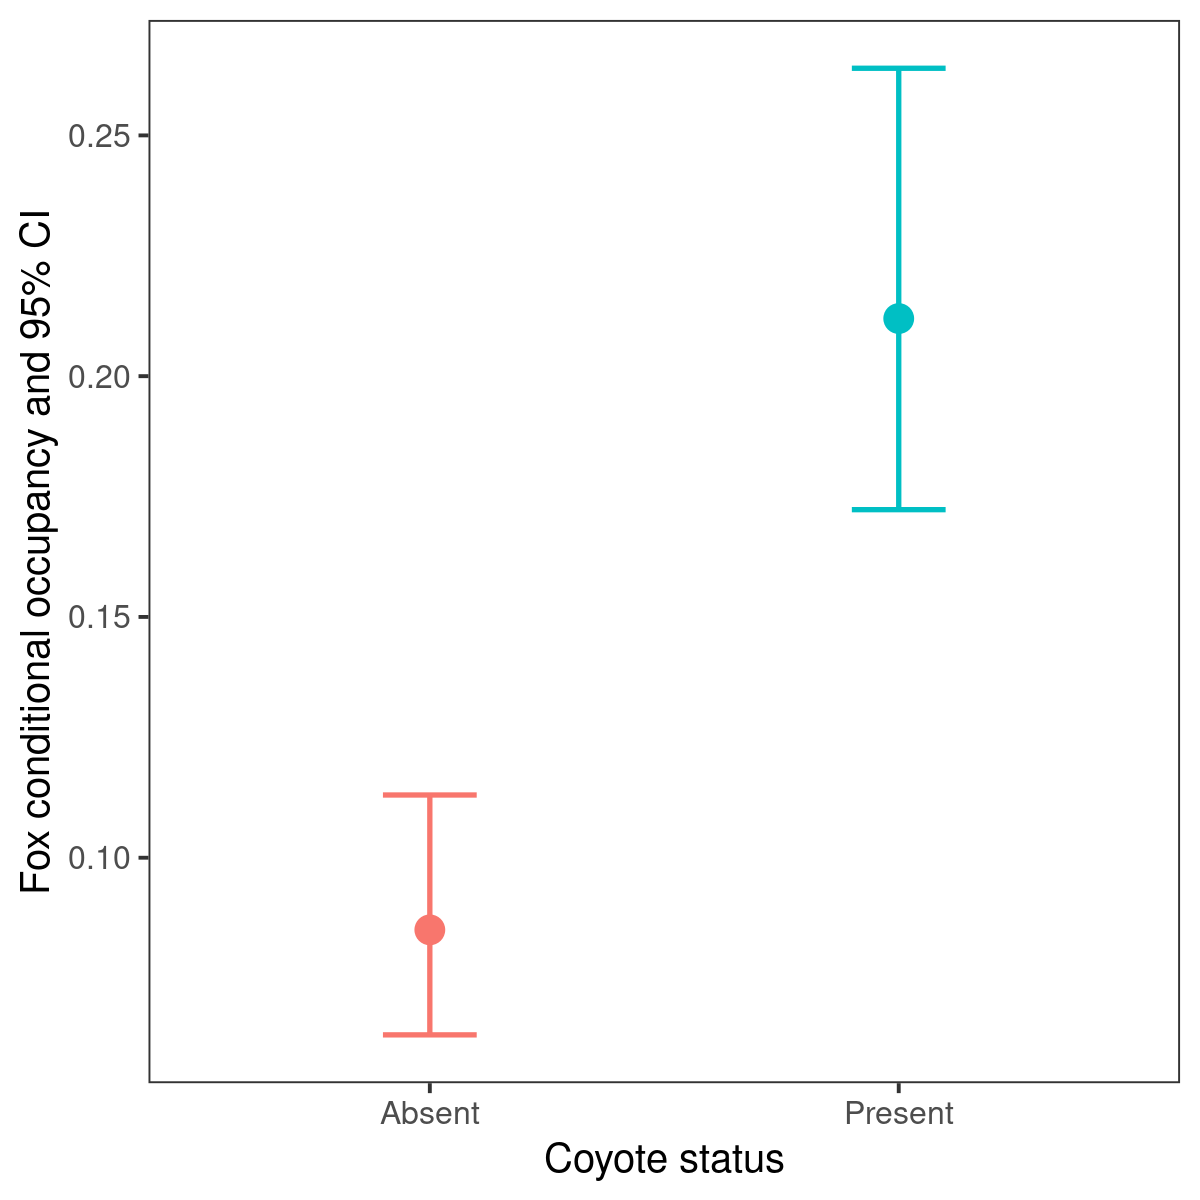

In [30]:
ggplot(data = plot_data, aes(x = Coyote_status, col=Coyote_status)) +
  geom_errorbar(aes(ymin = lower, ymax = upper), width = 0.2, size=1.5) +
  geom_point(aes(y = Predicted), size=8) +
  theme_bw(base_size = 24) +
  theme(panel.grid = element_blank(), legend.position='none') +
  labs(y = "Fox conditional occupancy and 95% CI", x = "Coyote status")

### Co-occurence (joint) probability

Probability that *both* species 1 and 2 are at a site (or some other arbitrary combo of species)

$$ \psi_{i, fox+coy} = \frac{\psi_{i{11}}}{\psi_{i{11}}+\psi_{i{10}} + \psi_{i{01}} + \psi_{i{00}}}$$

(Trivial for only 2 species)

In [31]:
colnames(occ_prob$Predicted)

[1] "psi[11]" "psi[10]" "psi[01]" "psi[00]"

In [32]:
cooccur_manual <- occ_prob$Predicted[,1] / rowSums(occ_prob$Predicted)
head(cooccur_manual)

[1] 0.07332333 0.07349727 0.07366480 0.07360916 0.07362022 0.07378003

Or with predict:

In [33]:
psi_coccur <- predict(mod_hdens, type="state", species=c("coyote","redfox"))
head(psi_coccur)

Bootstrapping confidence intervals with 100 samples



,Predicted,SE,lower,upper
,<dbl>,<dbl>,<dbl>,<dbl>
1,0.07332333,0.008872059,0.05911332,0.08740465
2,0.07349727,0.008894200,0.05926673,0.08763510
3,0.07366480,0.008915618,0.05941454,0.08785709
4,0.07360916,0.008908496,0.05936545,0.08778337
5,0.07362022,0.008909910,0.05937521,0.08779802
6,0.07378003,0.008930402,0.05950897,0.08800968


### Plotting covariate effects

To plot the effect of housing density on **marginal** occupancy, we again use `predict`.

1. Generate sequence of housing density values
2. Predict for each value
3. Plot 95% CI and estimate line

1. Generate sequence of possible `Hdens_5km` values for X-axis and put in data frame

NOTE: Even though we scaled this covariate in the analysis, we don't need to manually scale here. 

`unmarked` will do it for us because the scaling was specified *in the formula*.

In [34]:
hdens_range <- range(siteCovs(umf)$HDens_5km)
hdens_range
hdens_seq <- seq(hdens_range[1], hdens_range[2], length.out=100)
nd <- data.frame(HDens_5km = hdens_seq)

[1]   0.0000 186.6694

2. `predict` occupancy at each value of `Hdens_5km` along our sequence. Supply `nd` to `newdata` argument

We do this for both coyote and red fox separately:

In [35]:
occ_hdens_coy <- predict(mod_hdens, type="state", species="coyote", newdata=nd)
occ_hdens_coy$Species <- "Coyote"

occ_hdens_fox <- predict(mod_hdens, type="state", species="redfox", newdata=nd)
occ_hdens_fox$Species <- "Red fox"

Bootstrapping confidence intervals with 100 samples

Bootstrapping confidence intervals with 100 samples



Then combine the two pieces:

In [36]:
occ_hdens <- rbind(occ_hdens_coy, occ_hdens_fox)
occ_hdens$Hdens_5km = hdens_seq
head(occ_hdens)
tail(occ_hdens)

,Predicted,SE,lower,upper,Species,Hdens_5km
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,0.3415035,0.01526375,0.3099746,0.3694767,Coyote,0.000000
2,0.3423496,0.01511289,0.3105792,0.3689472,Coyote,1.885550
3,0.3432180,0.01503429,0.3114016,0.3683999,Coyote,3.771100
4,0.3441090,0.01502899,0.3123491,0.3698072,Coyote,5.656650
5,0.3450230,0.01509702,0.3133190,0.3707912,Coyote,7.542199
6,0.3459604,0.01523736,0.3139849,0.3717247,Coyote,9.427749


,Predicted,SE,lower,upper,Species,Hdens_5km
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
195,0.7424483,0.08212945,0.5603354,0.8631726,Red fox,177.2417
196,0.7487728,0.08183132,0.5662386,0.8679575,Red fox,179.1272
197,0.7549932,0.08150114,0.5721233,0.8725993,Red fox,181.0128
198,0.7611088,0.08113996,0.5779879,0.8771006,Red fox,182.8983
199,0.7671187,0.08074885,0.5838307,0.8814641,Red fox,184.7839
200,0.7730226,0.08032889,0.5896503,0.8856924,Red fox,186.6694


3. Make the plot

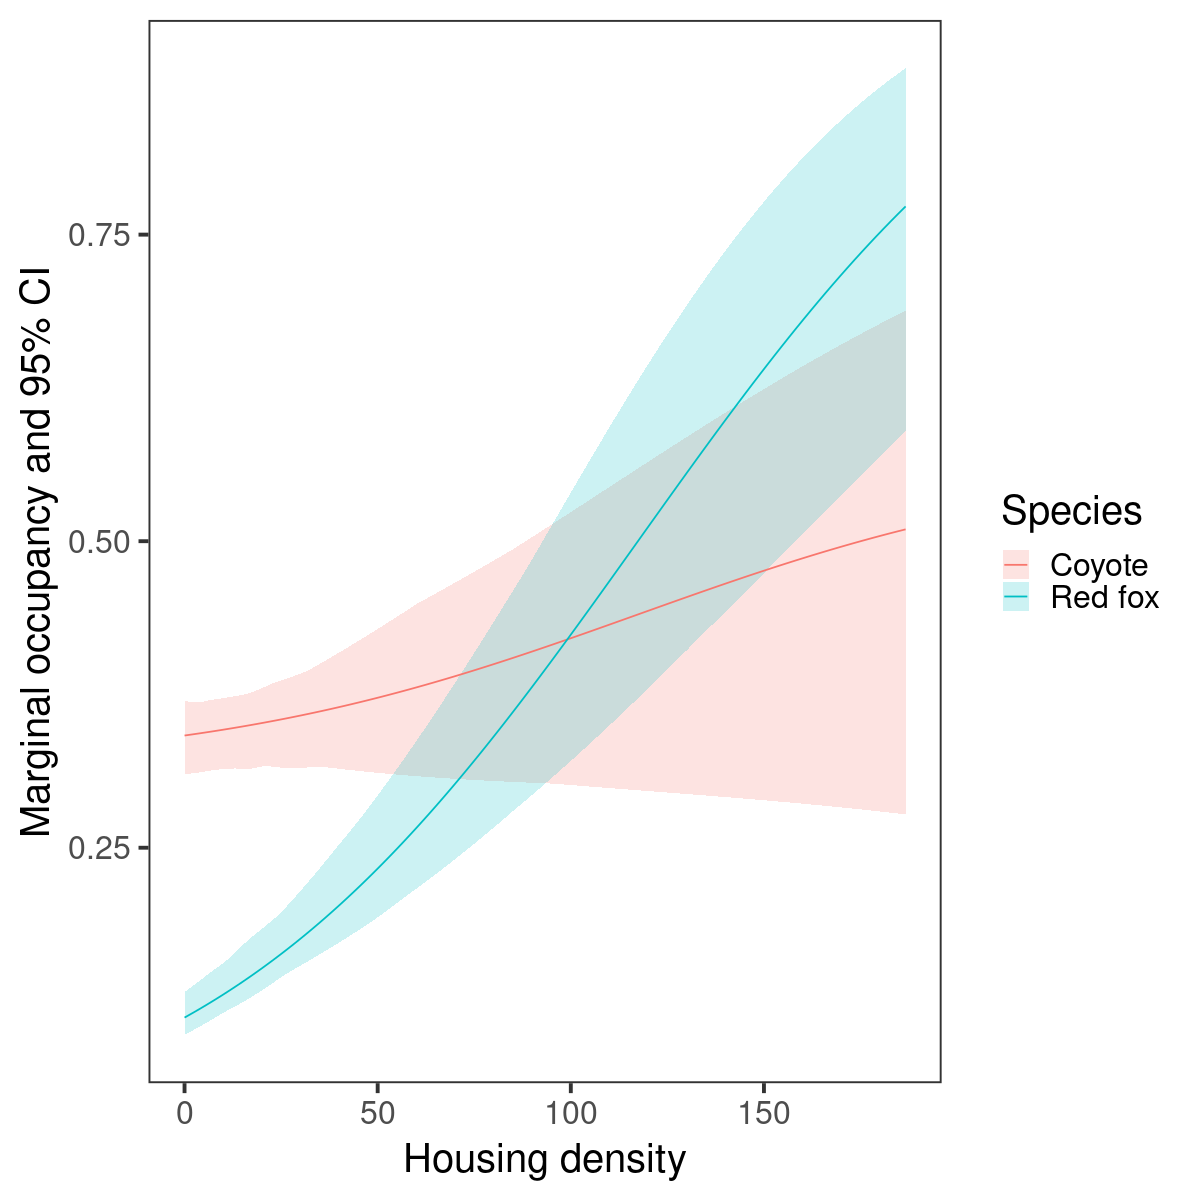

In [37]:
ggplot(data = occ_hdens, aes(x = Hdens_5km)) +
  geom_ribbon(aes(ymin = lower, ymax = upper, fill = Species), alpha = 0.2) +
  geom_line(aes(y = Predicted, col = Species)) +
  theme_bw(base_size = 24) +
  theme(panel.grid = element_blank()) +
  labs(y = "Marginal occupancy and 95% CI", x = "Housing density")

### Exercise: Plot conditional occupancy for a covariate

* Plot conditional occupancy of red fox as a function of housing density
* Do this for coyote present, coyote absent, or both (if you have time)
* Should be able to adapt code from previous section on marginal occupancy, just add the `cond` argument.

In [38]:
occ_hdens_coypres <- predict(mod_hdens, type="state", species="redfox", cond="coyote", newdata=nd)
occ_hdens_coypres$Coyote_status <- "Present"

occ_hdens_coyabs <- predict(mod_hdens, type="state", species="redfox", cond="-coyote", newdata=nd)
occ_hdens_coyabs$Coyote_status <- "Absent"

plot_hdens_coystatus <- rbind(occ_hdens_coypres, occ_hdens_coyabs)
plot_hdens_coystatus$Hdens_5km <- hdens_seq

Bootstrapping confidence intervals with 100 samples

Bootstrapping confidence intervals with 100 samples



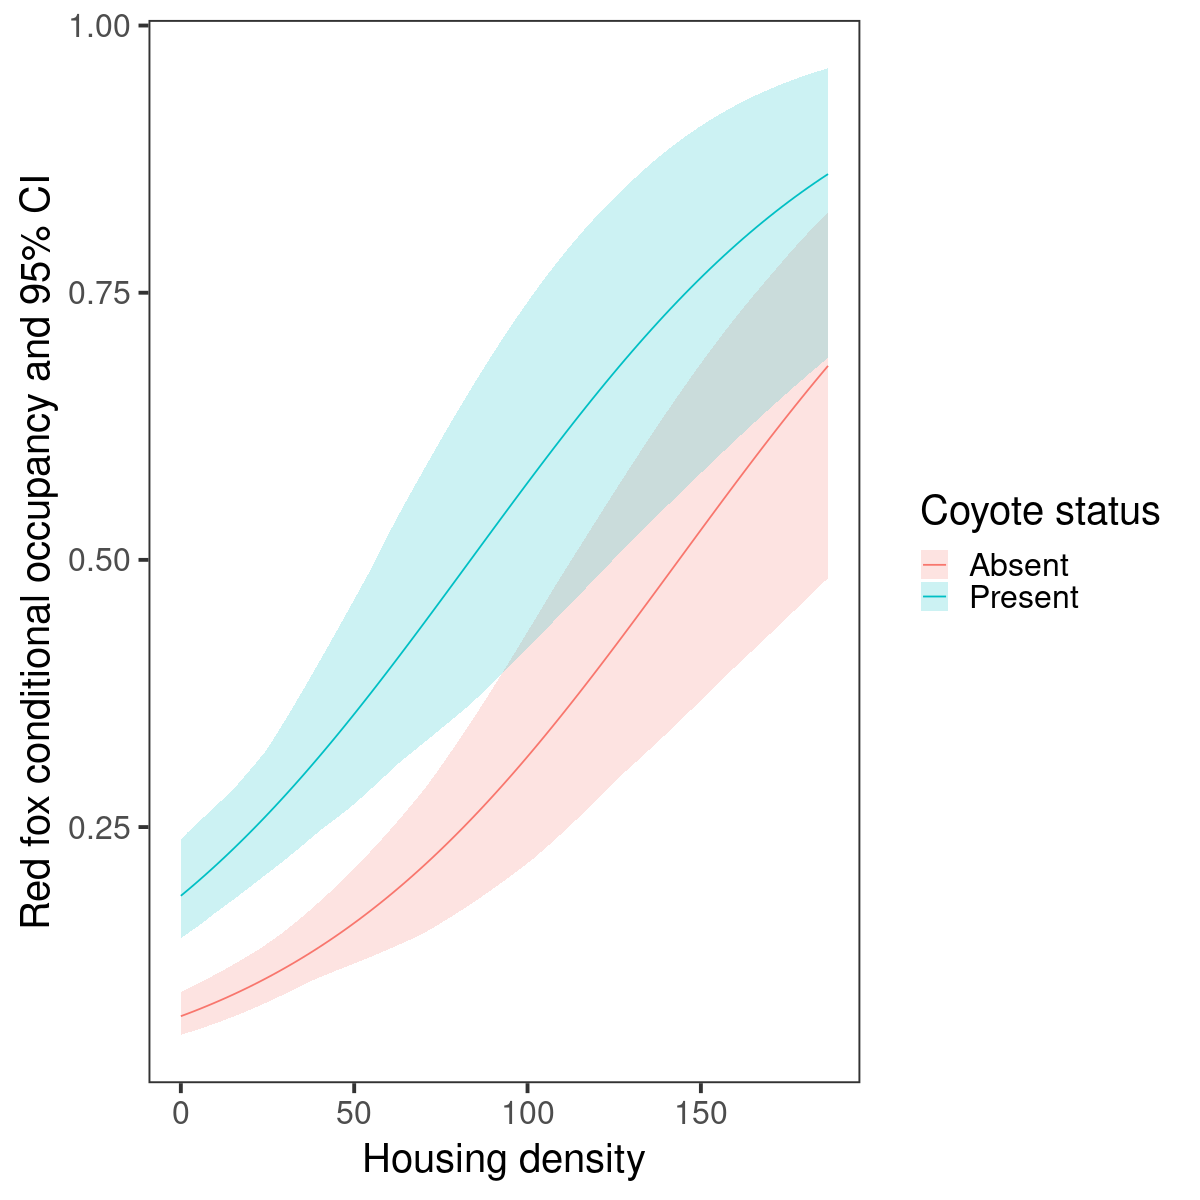

In [39]:
ggplot(data = plot_hdens_coystatus, aes(x = Hdens_5km)) +
  geom_ribbon(aes(ymin = lower, ymax = upper, fill = Coyote_status), alpha = 0.2) +
  geom_line(aes(y = Predicted, col = Coyote_status)) +
  theme_bw(base_size = 24) +
  theme(panel.grid = element_blank()) +
  labs(y = "Red fox conditional occupancy and 95% CI", x = "Housing density",
       col = "Coyote status", fill = "Coyote status")

Note these are parallel because `Hdens_5km` does not affect the interaction term.

# Removing interaction terms

(or "forcing interactions to 0")

This is pretty common. The two main reasons:

* 3-way and higher interactions are tough to interpret and rarely part of hypotheses
* Higher-order interactions are hard to estimate

Two options to remove interactions:

* Set corresponding formula to `"0"`
* Set `maxOrder` argument

Setting a formula to `"0"` removes just that particular interaction term.

Review the $f$ design matrix:

In [40]:
umf@fDesign

,f1[coyote],f2[redfox],f3[coyote:redfox]
psi[11],1,1,1
psi[10],1,0,0
psi[01],0,1,0
psi[00],0,0,0


In [41]:
stateformulas_0 <- c("~scale(HDens_5km)", "~scale(HDens_5km)", "0")
mod_noint <- occuMulti(detformulas=detformulas, stateformulas=stateformulas_0, data=umf)
mod_noint


Call:
occuMulti(detformulas = detformulas, stateformulas = stateformulas_0, 
    data = umf, maxOrder = 2L)

Occupancy:
                          Estimate     SE      z  P(>|z|)
[coyote] (Intercept)        -0.631 0.0745  -8.47 2.49e-17
[coyote] scale(HDens_5km)    0.108 0.0628   1.72 8.50e-02
[redfox] (Intercept)        -1.921 0.0998 -19.25 1.52e-82
[redfox] scale(HDens_5km)    0.514 0.0811   6.34 2.27e-10

Detection:
                     Estimate     SE     z  P(>|z|)
[coyote] (Intercept)   -0.332 0.0763 -4.36 1.33e-05
[redfox] (Intercept)   -0.261 0.1195 -2.19 2.87e-02

AIC: 4822.196 

Setting `maxOrder` gets rid of all interactions of above that level.

For example, `maxOrder = 1` means no interactions at all.

In [42]:
stateformulas <- c("~scale(HDens_5km)", "~scale(HDens_5km)")
mod_noint <- occuMulti(detformulas=detformulas, stateformulas=stateformulas, data=umf, maxOrder=1)
mod_noint


Call:
occuMulti(detformulas = detformulas, stateformulas = stateformulas, 
    data = umf, maxOrder = 1)

Occupancy:
                          Estimate     SE      z  P(>|z|)
[coyote] (Intercept)        -0.631 0.0745  -8.47 2.49e-17
[coyote] scale(HDens_5km)    0.108 0.0628   1.72 8.50e-02
[redfox] (Intercept)        -1.921 0.0998 -19.25 1.52e-82
[redfox] scale(HDens_5km)    0.514 0.0811   6.34 2.27e-10

Detection:
                     Estimate     SE     z  P(>|z|)
[coyote] (Intercept)   -0.332 0.0763 -4.36 1.33e-05
[redfox] (Intercept)   -0.261 0.1195 -2.19 2.87e-02

AIC: 4822.196 

This is equivalent to fitting two separate occupancy models.

For example, the coyote single-species model:

In [43]:
umf_coy <- unmarkedFrameOccu(y=ylist$coyote, siteCovs=site_covs)
occu(~1~scale(HDens_5km), umf_coy)


Call:
occu(formula = ~1 ~ scale(HDens_5km), data = umf_coy)

Occupancy:
                 Estimate     SE     z  P(>|z|)
(Intercept)        -0.631 0.0745 -8.47 2.51e-17
scale(HDens_5km)    0.108 0.0628  1.72 8.49e-02

Detection:
 Estimate     SE     z  P(>|z|)
   -0.332 0.0763 -4.36 1.32e-05

AIC: 3245.169 

# Model Selection

Use `fitList` and `modSel`, same as with single-species models.

In [44]:
fl <- fitList(hdens = mod_hdens, noint = mod_noint)
modSel(fl)

      nPars     AIC delta   AICwt cumltvWt
hdens     7 4800.86  0.00 1.0e+00     1.00
noint     6 4822.20 21.34 2.3e-05     1.00

### Exercise

* Set up a 3-species model with the `MesoCarnivores` dataset (i.e., add bobcat)
* Add more covariates if you want
* Don't include a 3-species interaction term (i.e., force it to be 0)

In [62]:
ylist <- MesoCarnivores[c(1:3)]
names(ylist)
umf <- unmarkedFrameOccuMulti(y=ylist, siteCovs=site_covs)
umf@fDesign

[1] "bobcat" "coyote" "redfox"

,f1[bobcat],f2[coyote],f3[redfox],f4[bobcat:coyote],f5[bobcat:redfox],f6[coyote:redfox],f7[bobcat:coyote:redfox]
psi[111],1,1,1,1,1,1,1
psi[110],1,1,0,1,0,0,0
psi[101],1,0,1,0,1,0,0
psi[100],1,0,0,0,0,0,0
psi[011],0,1,1,0,0,1,0
psi[010],0,1,0,0,0,0,0
psi[001],0,0,1,0,0,0,0
psi[000],0,0,0,0,0,0,0


In [63]:
stateformulas <- c("~scale(HDens_5km)","~scale(HDens_5km)","~scale(HDens_5km)","~1","~1","~1")
detformulas <- rep("~1", 3)
(mod_3species <- occuMulti(detformulas=detformulas, stateformulas=stateformulas, data=umf, maxOrder = 2))


Call:
occuMulti(detformulas = detformulas, stateformulas = stateformulas, 
    data = umf, maxOrder = 2)

Occupancy:
                            Estimate     SE      z  P(>|z|)
[bobcat] (Intercept)         -2.5364 0.2842  -8.92 4.53e-19
[bobcat] scale(HDens_5km)    -3.6008 0.9191  -3.92 8.94e-05
[coyote] (Intercept)         -1.3439 0.1470  -9.14 6.04e-20
[coyote] scale(HDens_5km)     0.0884 0.0742   1.19 2.34e-01
[redfox] (Intercept)         -2.2555 0.1566 -14.41 4.65e-47
[redfox] scale(HDens_5km)     0.4392 0.0831   5.29 1.24e-07
[bobcat:coyote] (Intercept)   1.8173 0.2714   6.70 2.16e-11
[bobcat:redfox] (Intercept)  -1.3385 0.3869  -3.46 5.42e-04
[coyote:redfox] (Intercept)   1.3740 0.2597   5.29 1.22e-07

Detection:
                     Estimate     SE     z  P(>|z|)
[bobcat] (Intercept)   -1.139 0.1421 -8.02 1.07e-15
[coyote] (Intercept)   -0.328 0.0759 -4.32 1.53e-05
[redfox] (Intercept)   -0.252 0.1179 -2.14 3.26e-02

AIC: 6530.476 

# Model fitting challenges

1. Amount of data required
2. Poor estimates

## Amount of data required

* You need a surprising amount of data to have high power to detect interaction effects
* We can explore this with simulation + power analysis

### Quick and very dirty review of power analysis

* Type I error: We reject the null hypothesis when in fact it is true.
* Type II error: We fail to reject the null hypothesis when in fact it is false.

* Power: 1 - Type II error (rule-of-thumb we want > 0.8)
* Power analysis: Determining power for a particular experimental design, effect size, and Type I error ($\alpha$)

Low power -> we fail to find an existing effect, or we run into other problems (more on this later)

We need to use simulation for doing power analysis with this model.

### Power analysis in `unmarked`

NOTE: The code below requires the dev version of `unmarked`

```r
remotes::install_github("rbchan/unmarked")
```

Information we need:

* A set of hypothetical effect sizes (= parameter values)
* An `unmarkedFrame` containing information about the experimental design
* Value of $\alpha$ (we'll leave at 0.05)

`unmarked` then automatically:

* Plugs effect sizes (= parameter values) into the template model
* Simulates new datasets and re-fits the models (many times)
* Checks parameter estimates for statistical significance at $\alpha$
* Summarizes the results as power

#### Effect sizes

We define a positive interaction between two species: when species 2 is present, species 1 is twice as likely to occupy a site.

First define $f$ values:

In [45]:
set.seed(123)

f1 <- 0.2
f2 <- 0.1
f12 <- 0.5 # <- EFFECT SIZE OF INTERACTION

For illustration, calculate the corresponding occupancy probabilities using the multinomial logit:

In [46]:
psi <- numeric(4)
psi[1] <- exp(f1 + f2 + f12)
psi[2] <- exp(f1)
psi[3] <- exp(f2)
psi[4] <- 1
psi <- psi / sum(psi)
names(psi) <- c("[11]","[10]","[01]","[00]")
round(psi, 3)

[11]  [10]  [01]  [00] 
0.401 0.220 0.199 0.180

Note probability of both species present [11] is twice as high as either species by itself.

This is a large interaction effect!

#### Create a template `unmarkedFrame`

Basically, a placeholder dataset with the correct design (number of sites, species, etc)

In [47]:
M <- 700 # sites
J <- 5   # occasions
y <- matrix(NA, M, J)
temp <- unmarkedFrameOccuMulti(list(y,y))
head(temp)

Data frame representation of unmarkedFrame object.
Only showing observation matrix for species 1.
   y.1 y.2 y.3 y.4 y.5
1   NA  NA  NA  NA  NA
2   NA  NA  NA  NA  NA
3   NA  NA  NA  NA  NA
4   NA  NA  NA  NA  NA
5   NA  NA  NA  NA  NA
6   NA  NA  NA  NA  NA
7   NA  NA  NA  NA  NA
8   NA  NA  NA  NA  NA
9   NA  NA  NA  NA  NA
10  NA  NA  NA  NA  NA

#### Try the power analysis

In addition to the information above, we need to provide any other required model settings.

In this case that's just the formulas.

In [48]:
sf <- c("~1", "~1", "~1") 
df <- c("~1", "~1")
pa700 <- powerAnalysis(temp, stateformulas=sf, detformulas=df)

effects should be a named list of vectors, with the following structure
        (replace 0s with your values):

$state
    [sp1] (Intercept)     [sp2] (Intercept) [sp1:sp2] (Intercept) 
                    0                     0                     0 

$det
[sp1] (Intercept) [sp2] (Intercept) 
                0                 0 



ERROR: Error: Specify effects argument as shown above


#### Format the effect sizes

In [49]:
ef <- list(state = c(f1, f2, f12), det = c(0, 0))

Note this list includes both effect sizes we are specifically interested in power for (`f12`) and also parameter values controlling other parts of the model.

Values of these other parameters will affect power! (e.g. low vs. high detection probability)

Also note that this is not detection probability of 0, the values are on the logit scale:

In [50]:
plogis(0)

[1] 0.5

#### Run the power analysis

In [51]:
pa700 <- powerAnalysis(temp, stateformulas=sf, detformulas=df, effects = ef)

Assumed parameter order for state:
[sp1] (Intercept), [sp2] (Intercept), [sp1:sp2] (Intercept)

Assumed parameter order for det:
[sp1] (Intercept), [sp2] (Intercept)



In [52]:
pa700

Model: occuMulti
Sites: 700
Primary Periods: 1
Occasions: 5
alpha: 0.05

Power Statistics:
 Submodel             Parameter Effect Power Type S Type M
    state [sp1:sp2] (Intercept)    0.5  0.86      0  1.098

#### Type S and M errors

If you suspect your study is underpowered, but find a significant effect, you may think: all is well.

But no.

**Type S error:** Probability of getting wrong **S**ign, given a significant effect

**Type M error:** Given a significant effect, how much larger is the reported effect expected to be relative to the 'true' effect? (**M**agnitude)

See Gelman and Carlin (2014).

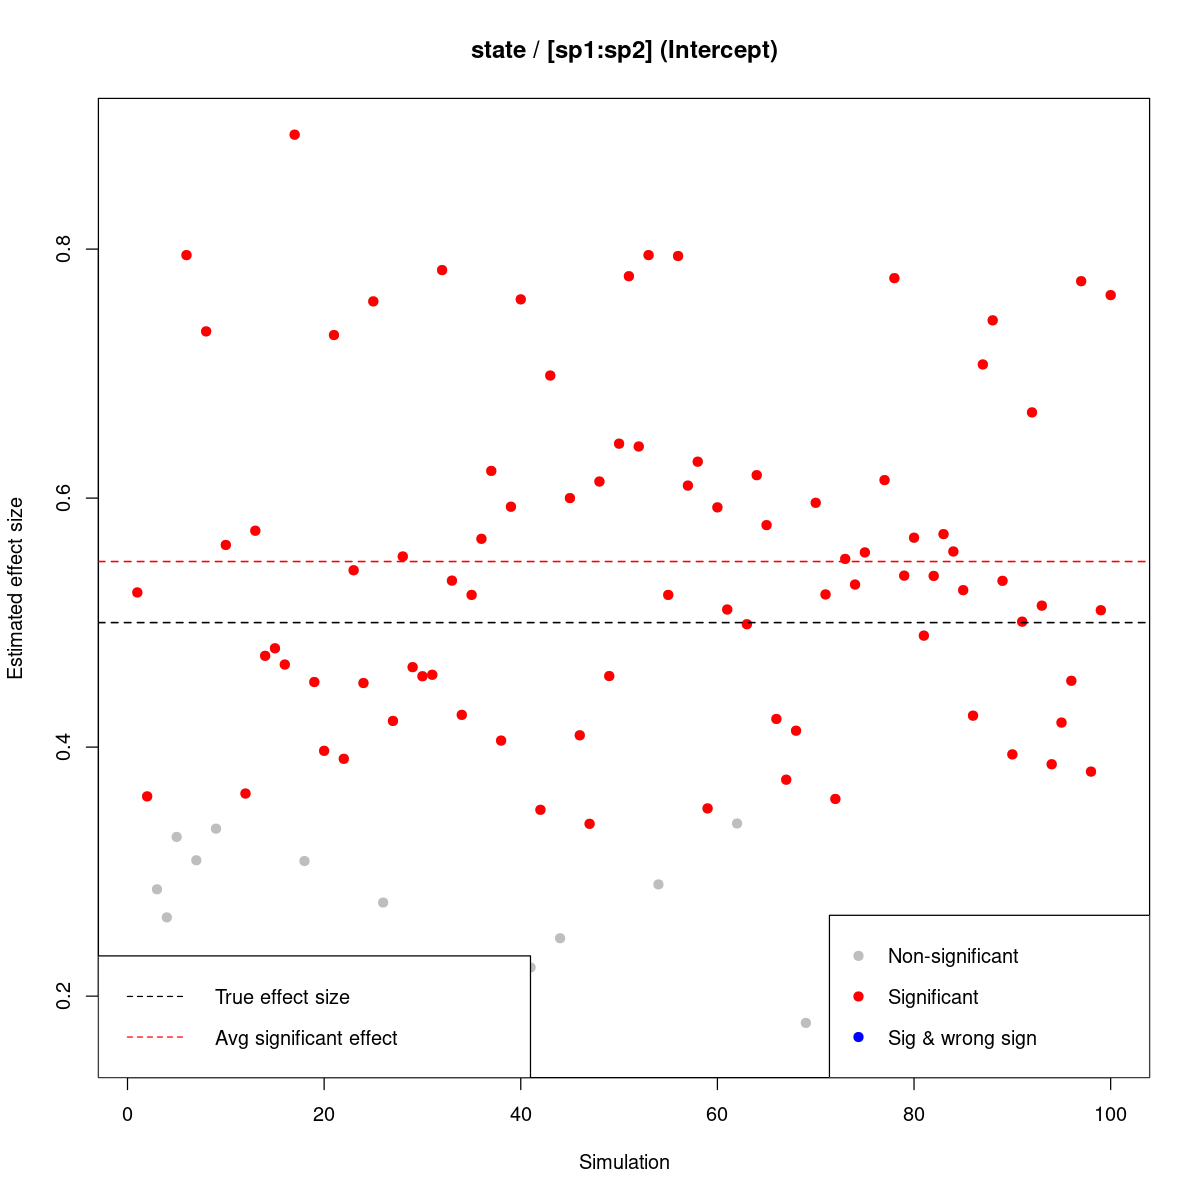

In [53]:
plot(pa700)

#### Run for a small sample size

In [54]:
pa100 <- powerAnalysis(temp[1:100,], stateformulas=sf, detformulas=df, effects = ef)
pa100

Assumed parameter order for state:
[sp1] (Intercept), [sp2] (Intercept), [sp1:sp2] (Intercept)

Assumed parameter order for det:
[sp1] (Intercept), [sp2] (Intercept)



Model: occuMulti
Sites: 100
Primary Periods: 1
Occasions: 5
alpha: 0.05

Power Statistics:
 Submodel             Parameter Effect Power Type S Type M
    state [sp1:sp2] (Intercept)    0.5  0.11      0  2.498

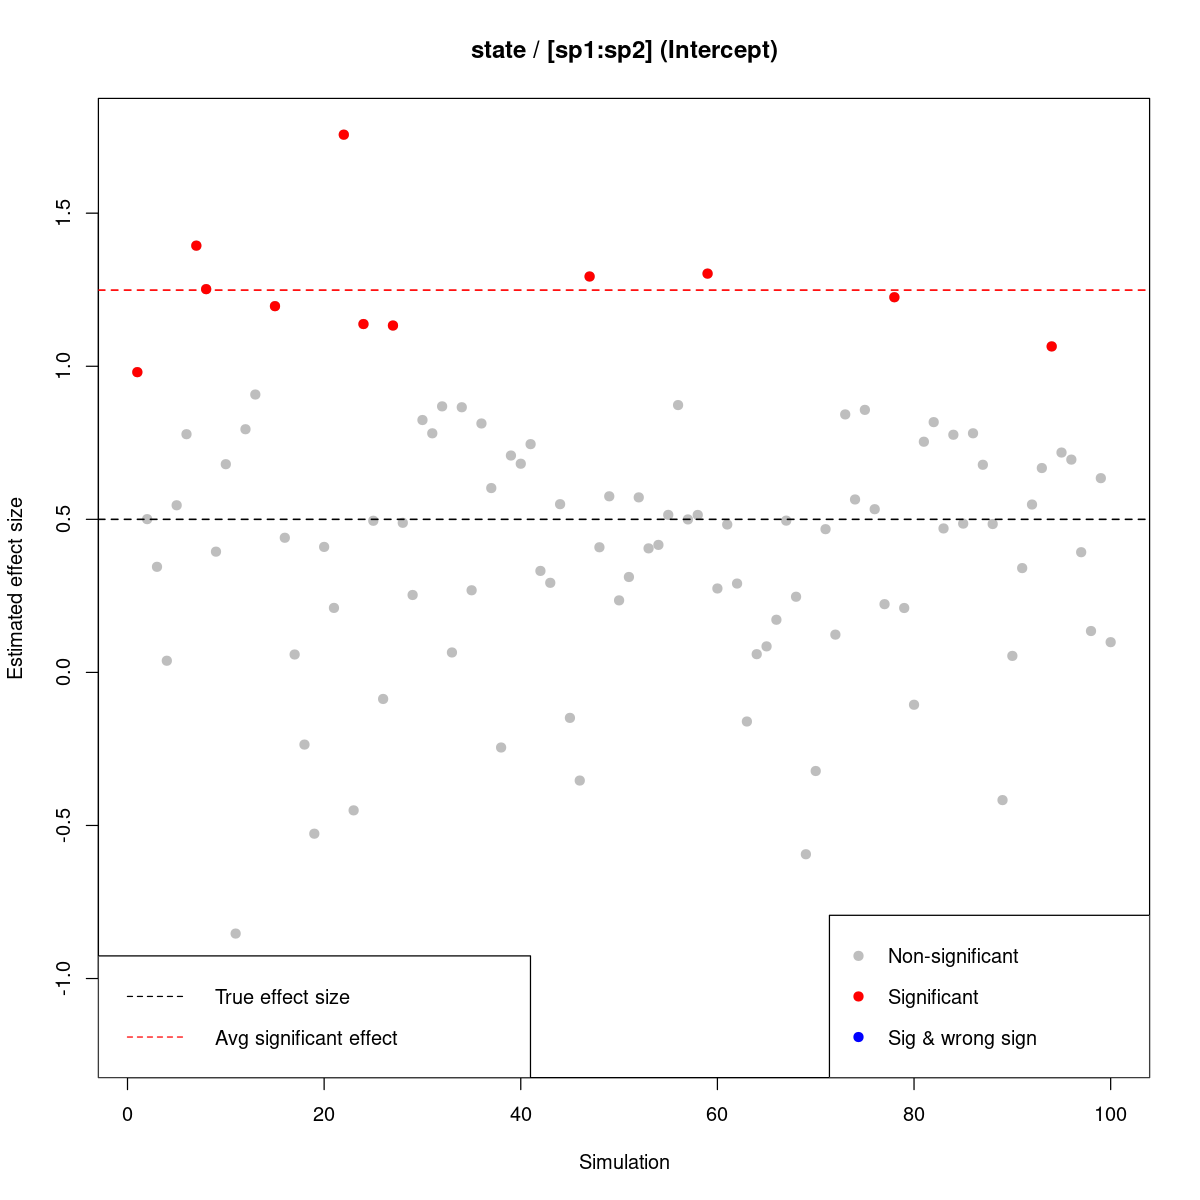

In [55]:
plot(pa100)

#### Draw a power curve

First do analyses for a couple more sample sizes.

In [56]:
pa300 <- powerAnalysis(temp[1:300,], stateformulas=sf, detformulas=df, effects = ef)
pa500 <- powerAnalysis(temp[1:500,], stateformulas=sf, detformulas=df, effects = ef)

Assumed parameter order for state:
[sp1] (Intercept), [sp2] (Intercept), [sp1:sp2] (Intercept)

Assumed parameter order for det:
[sp1] (Intercept), [sp2] (Intercept)

Assumed parameter order for state:
[sp1] (Intercept), [sp2] (Intercept), [sp1:sp2] (Intercept)

Assumed parameter order for det:
[sp1] (Intercept), [sp2] (Intercept)



Finally, combine all the power analyses into a list for comparison and plot power for the interaction term.

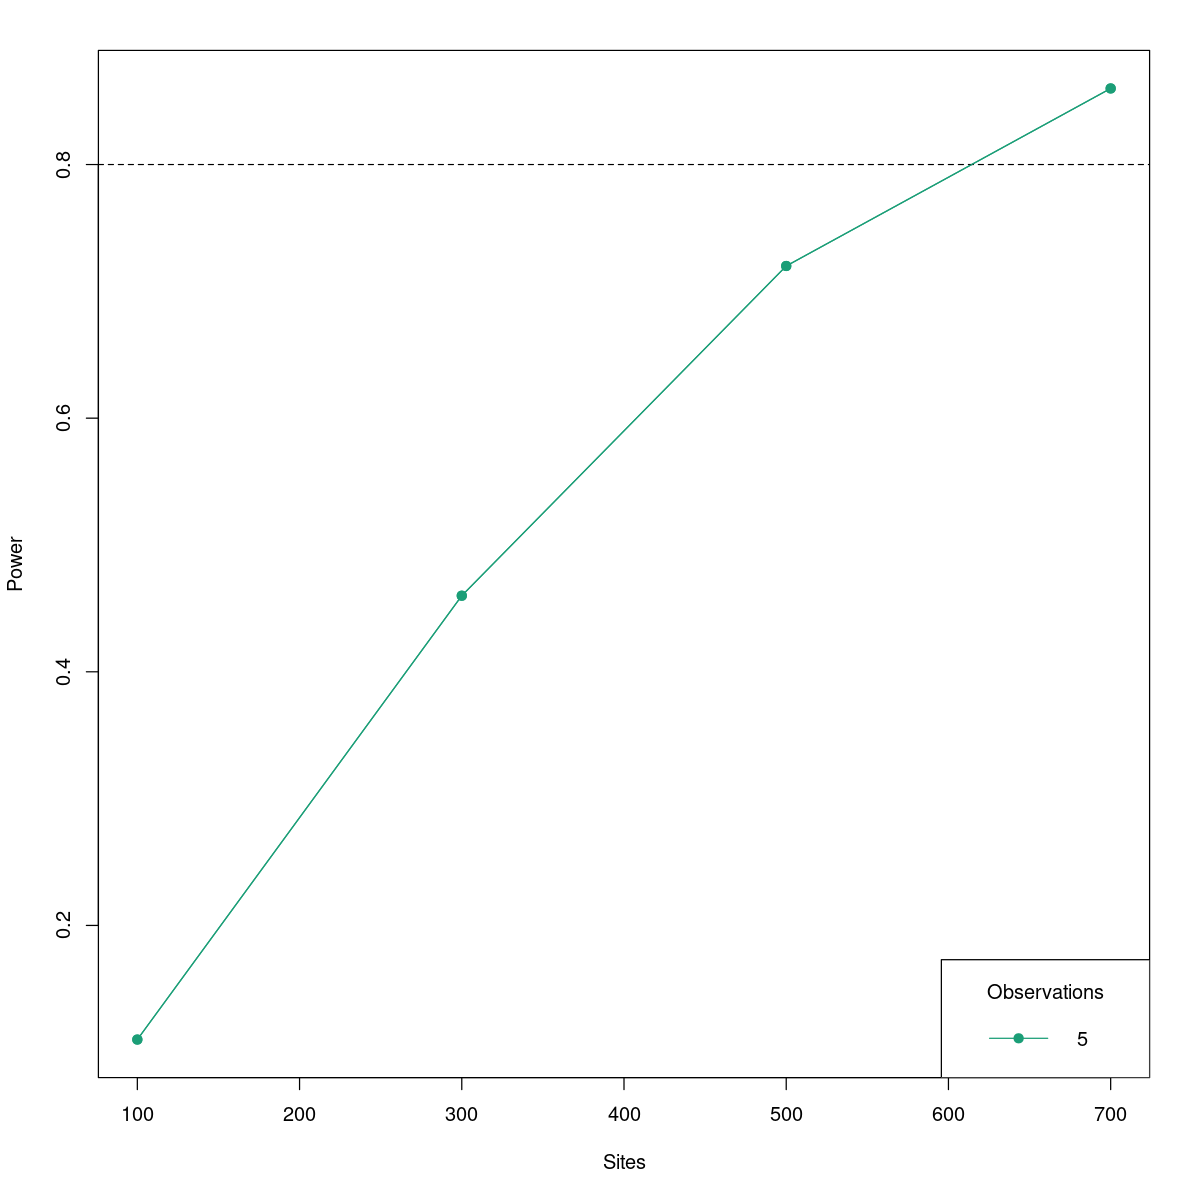

In [57]:
pl <- unmarkedPowerList(list(pa100, pa300, pa500, pa700))

plot(pl, power=0.8)

We need quite a few sites (~700) to have adequate power to detect a significant positive interaction, even when the effect size is relatively large!

I think many studies using this model are under-powered.

## Poor estimates

* You might get poor estimates under certain conditions:
    - Sparse data (many 0s)
    - Boundary estimates (occupancy close to 0 or 1)
    - Few observations where multiple species are detected
    - Separation (perfect correlation with covariate)
* What do I mean by poor estimates? Very large absolute values and SEs

In [64]:
state_complex <- c(rep("~scale(Dist_5km)+scale(HDens_5km)", 6), 0)
det_complex <- rep("~Trail",3)

mod_complex <- occuMulti(stateformulas=state_complex, detformulas=det_complex, umf)
mod_complex


Call:
occuMulti(detformulas = det_complex, stateformulas = state_complex, 
    data = umf, maxOrder = 3L)

Occupancy:
                                 Estimate     SE      z  P(>|z|)
[bobcat] (Intercept)             -23.0171  5.787 -3.977 6.97e-05
[bobcat] scale(Dist_5km)          -2.4249  0.689 -3.518 4.34e-04
[bobcat] scale(HDens_5km)        -82.3836 19.799 -4.161 3.17e-05
[coyote] (Intercept)              -0.6789  0.225 -3.017 2.55e-03
[coyote] scale(Dist_5km)          -0.0176  0.139 -0.127 8.99e-01
[coyote] scale(HDens_5km)         -0.5534  0.748 -0.740 4.59e-01
[redfox] (Intercept)              -1.3946  0.257 -5.425 5.79e-08
[redfox] scale(Dist_5km)          -0.5293  0.250 -2.114 3.45e-02
[redfox] scale(HDens_5km)          0.2108  0.261  0.808 4.19e-01
[bobcat:coyote] (Intercept)        6.7598  6.390  1.058 2.90e-01
[bobcat:coyote] scale(Dist_5km)    1.6979  0.695  2.444 1.45e-02
[bobcat:coyote] scale(HDens_5km)  17.9202 21.460  0.835 4.04e-01
[bobcat:redfox] (Intercept)       15

### Potential Solutions

* Fewer covariates
* Fewer species
* Adjust observation period length if possible
* Set higher-order interaction terms to 0
* Penalized likelihood with `optimizePenalty` function (Clipp et al. 2021)
* Bayesian framework

### Penalized likelihood

"Bayes-inspired" penalty (Hutchinson et al. 2015):

$$
-\lambda\frac{1}{2}\sum_i{}\theta_i^2
$$

Where $\theta$ is the vector of parameter estimates.

Size of penalty increases as values of $\theta$ increase.

Tradeoff:
* Introduce small bias in parameter estimates
* Potentially large reduction in variance

```r
mod_penalty <- occuMulti(stateformulas=state_complex, detformulas=det_complex, umf, penalty=1)
mod_penalty
```

```r
Bootstraping covariance matrix


Call:
occuMulti(detformulas = det_complex, stateformulas = state_complex, 
    data = umf, penalty = 1, maxOrder = 3L)

Occupancy:
                                 Estimate    SE      z  P(>|z|)
[bobcat] (Intercept)              -1.7810 0.269 -6.627 3.43e-11
[bobcat] scale(Dist_5km)          -1.3143 0.293 -4.491 7.08e-06
[bobcat] scale(HDens_5km)         -2.8200 0.539 -5.230 1.70e-07
[coyote] (Intercept)              -0.6049 0.214 -2.830 4.66e-03
[coyote] scale(Dist_5km)           0.0285 0.106  0.270 7.87e-01
[coyote] scale(HDens_5km)         -1.0908 0.378 -2.887 3.88e-03
[redfox] (Intercept)              -1.5659 0.305 -5.140 2.75e-07
[redfox] scale(Dist_5km)          -0.3068 0.157 -1.958 5.02e-02
[redfox] scale(HDens_5km)          0.4730 0.546  0.867 3.86e-01
[bobcat:coyote] (Intercept)        1.1871 0.434  2.736 6.22e-03
[bobcat:coyote] scale(Dist_5km)    0.9347 0.346  2.705 6.84e-03
[bobcat:coyote] scale(HDens_5km)  -0.3218 1.008 -0.319 7.50e-01
[bobcat:redfox] (Intercept)       -0.8831 0.347 -2.545 1.09e-02
[bobcat:redfox] scale(Dist_5km)    0.0364 0.305  0.119 9.05e-01
[bobcat:redfox] scale(HDens_5km)   2.5609 1.074  2.384 1.71e-02
[coyote:redfox] (Intercept)        1.0001 0.310  3.227 1.25e-03
[coyote:redfox] scale(Dist_5km)    0.0236 0.167  0.141 8.87e-01
[coyote:redfox] scale(HDens_5km)   1.3920 0.345  4.030 5.57e-05

Detection:
                     Estimate     SE      z  P(>|z|)
[bobcat] (Intercept)    -2.44 0.1755 -13.89 7.63e-44
[bobcat] Trail           1.74 0.1966   8.87 7.25e-19
[coyote] (Intercept)    -1.89 0.0926 -20.45 5.64e-93
[coyote] Trail           2.10 0.1179  17.84 3.31e-71
[redfox] (Intercept)    -1.49 0.1782  -8.35 6.64e-17
[redfox] Trail           1.72 0.1714  10.04 9.73e-24

AIC: 6135.555 
```

How to choose penalty value? `optimizePenalty()` function.

This uses K-fold cross-validation to pick the "best" penalty value.

```r
mod_penalty <- optimizePenalty(mod_complex, penalties=c(0.5,1))
```

### Literature Cited

Clipp, H.L., Evans, A.L., Kessinger, B.E., Kellner, K. and Rota, C.T. (2021). A penalized likelihood for multispecies occupancy models improves predictions of species interactions. Ecology, p.e03520.

Gelman, A., and Carlin, J. (2014). Beyond power calculations: Assessing type S (sign) and type M (magnitude) errors. Perspectives on Psychological Science, 9(6), 641-651.

MacKenzie, D. I., Bailey, L. L., & Nichols, J. D. (2004). Investigating species co‐occurrence patterns when species are detected imperfectly. Journal of Animal Ecology, 73(3), 546-555.

Richmond, O.M., Hines, J.E. and Beissinger, S.R. (2010). Two‐species occupancy models: a new parameterization applied to co‐occurrence of secretive rails. Ecological Applications, 20(7), pp.2036-2046.

Ridout, M. S., & Linkie, M. (2009). Estimating overlap of daily activity patterns from camera trap data. Journal of Agricultural, Biological, and Environmental Statistics, 14, 322-337.

Rota, C.T., Ferreira, M.A., Kays, R.W., Forrester, T.D., Kalies, E.L., McShea, W.J., Parsons, A.W. and Millspaugh, J.J. (2016). A multispecies occupancy model for two or more interacting species. Methods in Ecology and Evolution, 7(10), pp.1164-1173.

Waddle, J.H., Dorazio, R.M., Walls, S.C., Rice, K.G., Beauchamp, J., Schuman, M.J. and Mazzotti, F.J. (2010). A new parameterization for estimating co‐occurrence of interacting species. Ecological Applications, 20(5), pp.1467-1475.